In [1]:
# Dependencies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load data (FRED-MD)
df = pd.read_csv('../current.csv')

# Remove the first row (transformation codes)
transformation_codes = df.iloc[0]  # Transformation codes can be applied if needed
df = df.iloc[1:]

# Set the first column as the index and datetime
df.set_index(df.columns[0], inplace=True)
df.index = pd.to_datetime(df.index)

# Dropna
data = df.dropna()

# Create train data and target
target = (data['CPIAUCSL'].diff(12) / data['CPIAUCSL'].shift(12)) * 100
target = target.shift(-12).dropna()
data = data.loc[target.index]
train = data.dropna()

In [5]:
series = target.values
fp = "ar.csv"

for forecast_horizon in range(49, 52):
    for context_window in range(1, 24):
        # Split data into train and test sets
        cutoff = len(series) - forecast_horizon
        train_data = series[:cutoff]

        # Fit the AutoReg model
        model = AutoReg(train_data, lags=context_window, old_names=False)
        results = model.fit()

        # Make predictions
        forecast = results.predict(
            start=cutoff, 
            end=cutoff + forecast_horizon - 1, 
            dynamic=True # true forecasting
        )

        # Actual values
        y_true = series[-forecast_horizon:]
        y_pred = forecast[:forecast_horizon]

        # Calculate errors
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)

        # Log
        ar_log = pd.read_csv(fp) # forecast_horizon,context_window,dropout_rate,rmse,mae,forecast,true_vals
        new_row = {
            'horizon': forecast_horizon,
            'lags': context_window,
            'rmse': rmse,
            'mae': mae,
            'forecast': list(y_pred),
            'actual': list(y_true)
        }
        ar_log = pd.concat([ar_log, pd.DataFrame([new_row])], ignore_index=True)
        ar_log.to_csv(fp, index=False)

In [6]:
# Rm duplicate rows
import pandas as pd
data = pd.read_csv("ar.csv")

# Merge duplicate rows
data = data.groupby(['horizon', 'lags'], as_index=False).agg({
    'rmse': 'mean',
    'mae': 'mean',
    'forecast': lambda x: list(x),
    'actual': lambda x: list(x)
})
data.to_csv("ar.csv", index=False)


                            OLS Regression Results                            
Dep. Variable:                   rmse   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     1854.
Date:                Fri, 11 Apr 2025   Prob (F-statistic):               0.00
Time:                        08:01:10   Log-Likelihood:                -904.33
No. Observations:                1175   AIC:                             1817.
Df Residuals:                    1171   BIC:                             1837.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.5709      0.064     -8.925      

,horizon,rmse,lags,interaction
0,1,0.004818,17,17
1,2,0.013518,13,26
2,3,0.063908,13,39
3,4,0.080616,13,52
4,5,0.322019,18,90
5,6,0.299424,10,60
6,7,0.269287,11,77
7,8,0.237955,10,80
8,9,0.279878,16,144
9,10,0.233840,9,90


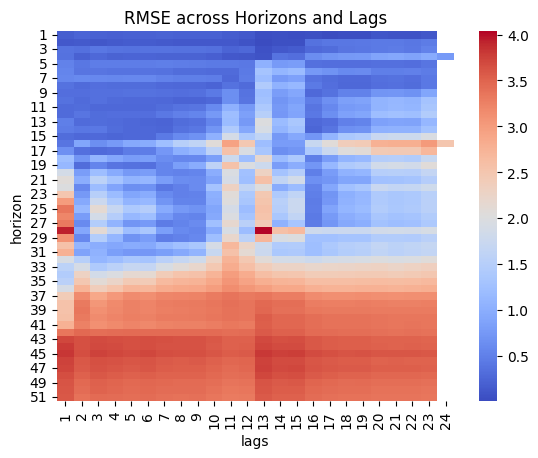

In [25]:
# Look at minimum RMSE per horizon
import pandas as pd
data = pd.read_csv("ar.csv")[["horizon", "lags", "rmse"]]

correlation = data.corr(method='pearson')

import seaborn as sns
import matplotlib.pyplot as plt
pivot = data.pivot(index='horizon', columns='lags', values='rmse')
sns.heatmap(pivot, annot=False, cmap='coolwarm')
plt.title("RMSE across Horizons and Lags")

import statsmodels.formula.api as smf
data['interaction'] = data['horizon'] * data['lags']
model = smf.ols("rmse ~ horizon + lags + interaction", data=data).fit()
print(model.summary())

# Get the minimum RMSE for each forecast horizon
min_rmse = data.groupby('horizon')['rmse'].min().reset_index()
# Merge with original data to get the context window
min_rmse = min_rmse.merge(data, on=['horizon', 'rmse'])
min_rmse